In [5]:
import sys
import math
import numpy as np
from scipy.stats import norm

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sys.path.append('..')
from higgs_inference import settings
from higgs_inference.various.utils import format_number, weighted_quantile

# Recalibration sample

In [13]:
folders = ['truth'] + ['score_regression'] * 2 + ['parameterized'] * 4
filenames = ['truth',
             'scoreregression_score_deep',
             'scoreregression_scoretheta_deep',
             'carl_calibrated_shallow',
             'regression_calibrated',
             'combined_calibrated_deep',
             'combinedregression_calibrated_deep']
n_strategies = len(filenames)


In [14]:
r_expectations = []

for filename, folder in zip(filenames, folders):
    r_expectations.append(np.load('../results/' + folder + '/recalibration_expected_r_vs_sm_' + filename + '.npy'))
    

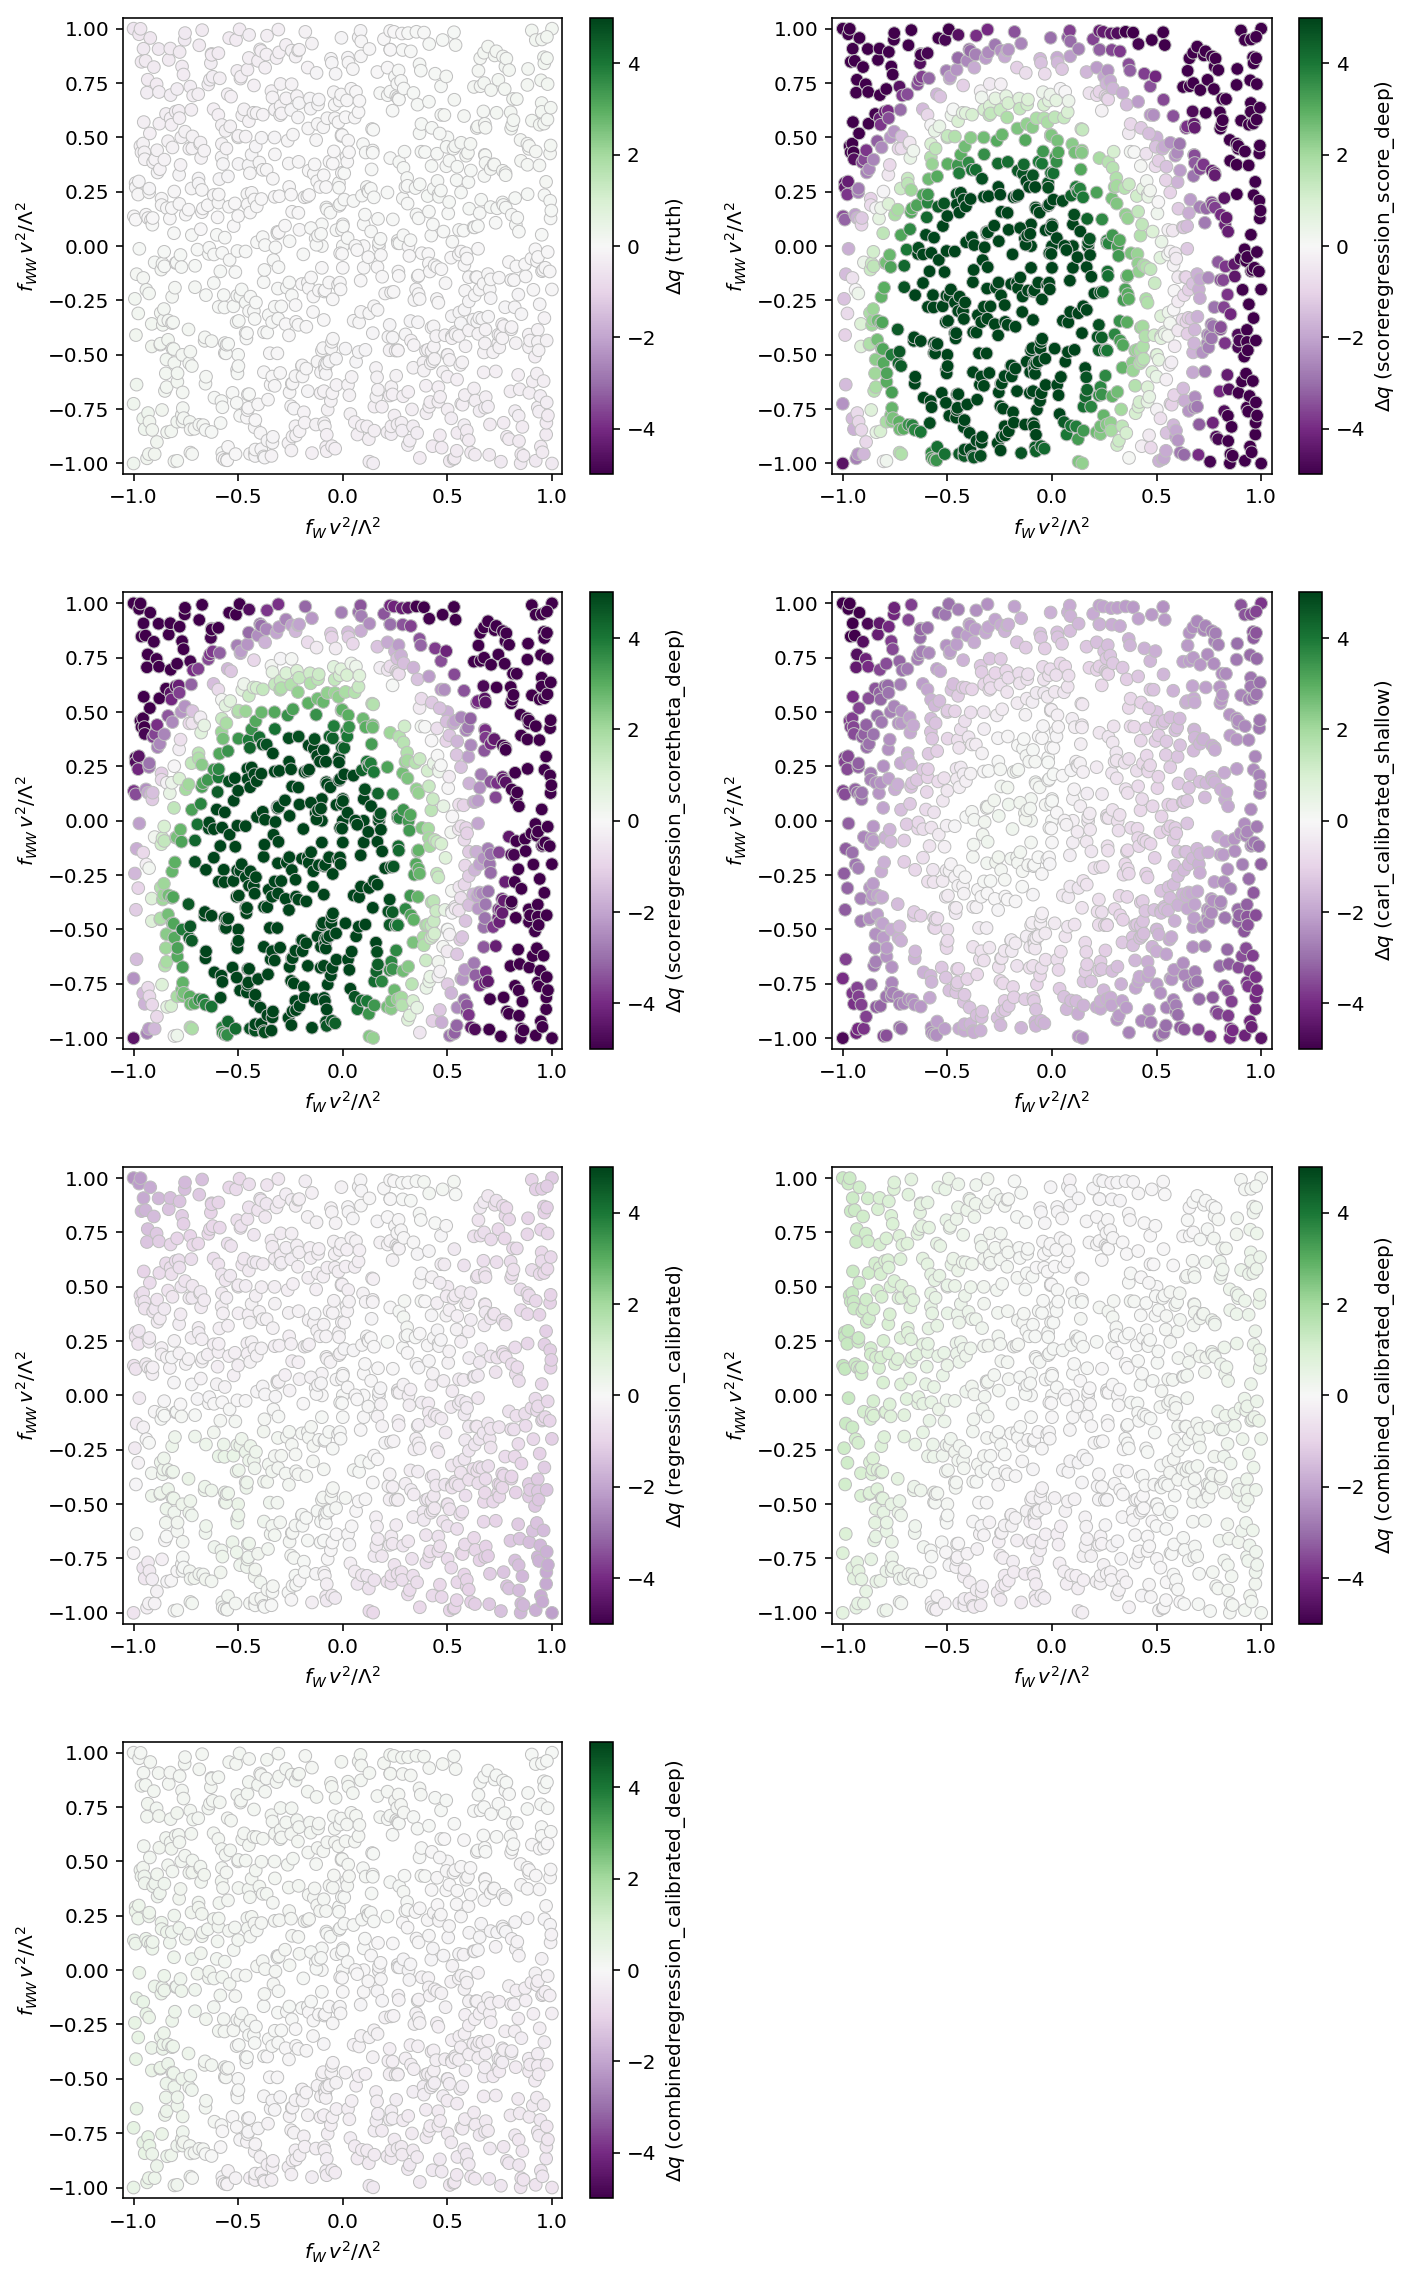

In [21]:
n_rows = int(math.ceil(n_strategies / 2.))

plt.figure(figsize=(10,n_rows * 4))

for i, (r_expectation, filename) in enumerate(zip(r_expectations, filenames)):

    plt.subplot(n_rows, 2, i+1)
    plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=72 * np.log(r_expectation),
                s=40.,
                edgecolor='0.75', lw=0.5,
                cmap='PRGn',
                vmin=-5., vmax=5.)

    cbar = plt.colorbar()

    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$\Delta q$ (' + filename + ')')
    
plt.tight_layout()

# Training sample

In [2]:
# Training data
r_train = np.load('../data/unweighted_events/r_train_new.npy')
y_train = np.load('../data/unweighted_events/y_train_new.npy')
rhat_train = np.load('../results/parameterized/r_train_combinedregression_deep_new.npy')

# Find events for thetas, generated according to theta1
indices_theta1 = [ [] for t in range(settings.n_thetas)]
indices_theta0 = [ [] for t in range(settings.n_thetas)]
t = 17
last = 0
for i, y in enumerate(y_train):
    if y == 1:
        indices_theta1[t].append(i)
        last = 1
    elif y == 0:
        if last == 1: # Done with a theta
            t += 1
        indices_theta0[t].append(i)
        last = 0
    else:
        print(y)
        

In [5]:
expected_r = np.zeros(settings.n_thetas)
expected_r_std = np.zeros(settings.n_thetas)
expected_r_std_50k = np.zeros(settings.n_thetas)
expected_rhat = np.zeros(settings.n_thetas)
error = np.zeros(settings.n_thetas)

for t in range(settings.n_thetas):
    if len(indices_theta1[t]) > 0:
        expected_r[t] = np.mean(r_train[indices_theta1[t]])
        expected_rhat[t] = np.mean(rhat_train[indices_theta1[t]])
        error[t] = np.mean(rhat_train[indices_theta1[t]] / r_train[indices_theta1[t]])
    else:
        expected_r[t] = np.nan
        expected_rhat[t] = np.nan
        error[t] = np.nan
        
    if len(indices_theta0[t]) > 0 and len(indices_theta1[t]) > 0:
        expected_r_std[t] = (1. / len(indices_theta1[t]) * (np.mean(r_train[indices_theta0[t]]) - 1.))**0.5
    else:
        expected_r_std[t] = np.nan
        
    if len(indices_theta0[t]) > 0 and len(indices_theta1[t]) > 0:
        expected_r_std_50k[t] = (1. / 50000. * (np.mean(r_train[indices_theta0[t]]) - 1.))**0.5
    else:
        expected_r_std_50k[t] = np.nan
        

# True data on training sample

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in true_divide
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in true_divide
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value en

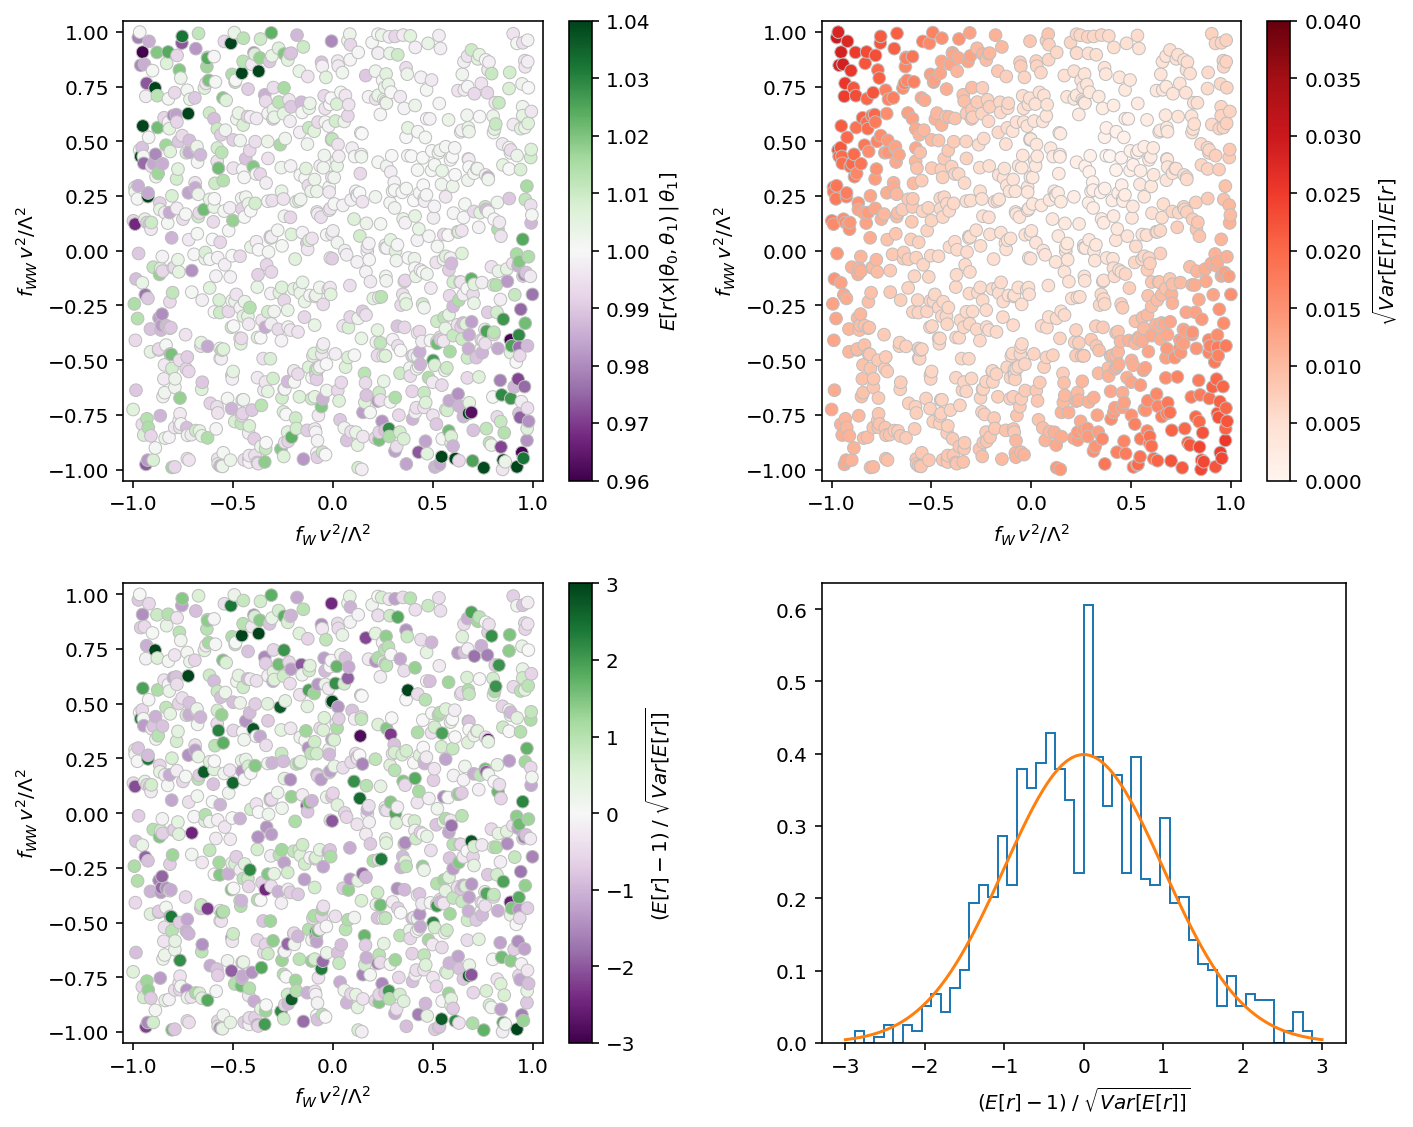

In [6]:
plt.figure(figsize=(10,8))



plt.subplot(2,2,1)

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=expected_r,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='PRGn',
            vmin=0.96, vmax=1.04)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$E[r(x | \theta_0, \theta_1) \,|\, \theta_1]$')



plt.subplot(2,2,2)

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=expected_r_std / expected_r,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='Reds',
            vmin=0., vmax=0.04)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\sqrt{Var[E[r]]} / E[r]$')



plt.subplot(2,2,3)

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=(expected_r - 1) / expected_r_std,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='PRGn',
            vmin=-3., vmax=3.)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$(E[r] - 1) \; / \; \sqrt{Var[E[r]]}$')



plt.subplot(2,2,4)

plt.hist((expected_r - 1) / expected_r_std, bins=50, range=(-3.,3.),
          histtype='step', density=True)
plt.plot(np.linspace(-3.,3.,100), norm.pdf(np.linspace(-3.,3.,100)), c='C1')
plt.xlabel(r"$(E[r] - 1) \; / \; \sqrt{Var[E[r]]}$")



plt.tight_layout()
plt.show()

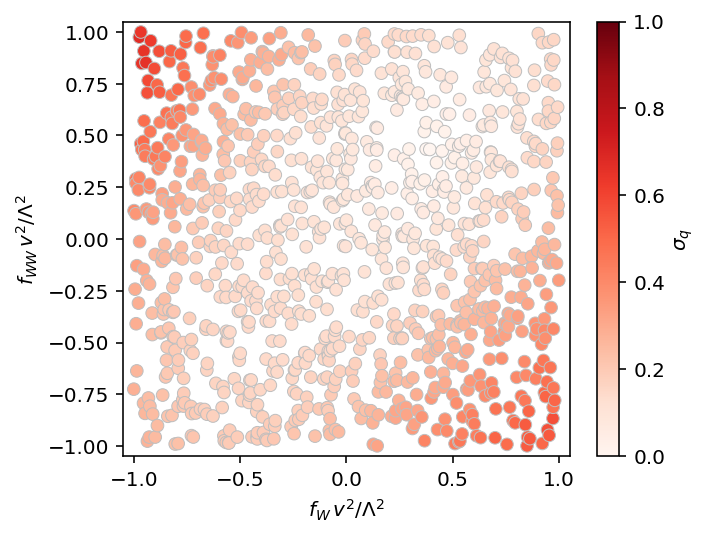

In [14]:
plt.figure(figsize=(5,4))

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=2. * 36. * expected_r_std_50k / expected_r,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='Reds',
            vmin=0., vmax=1.)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$\sigma_q$')

# Estimator on training sample

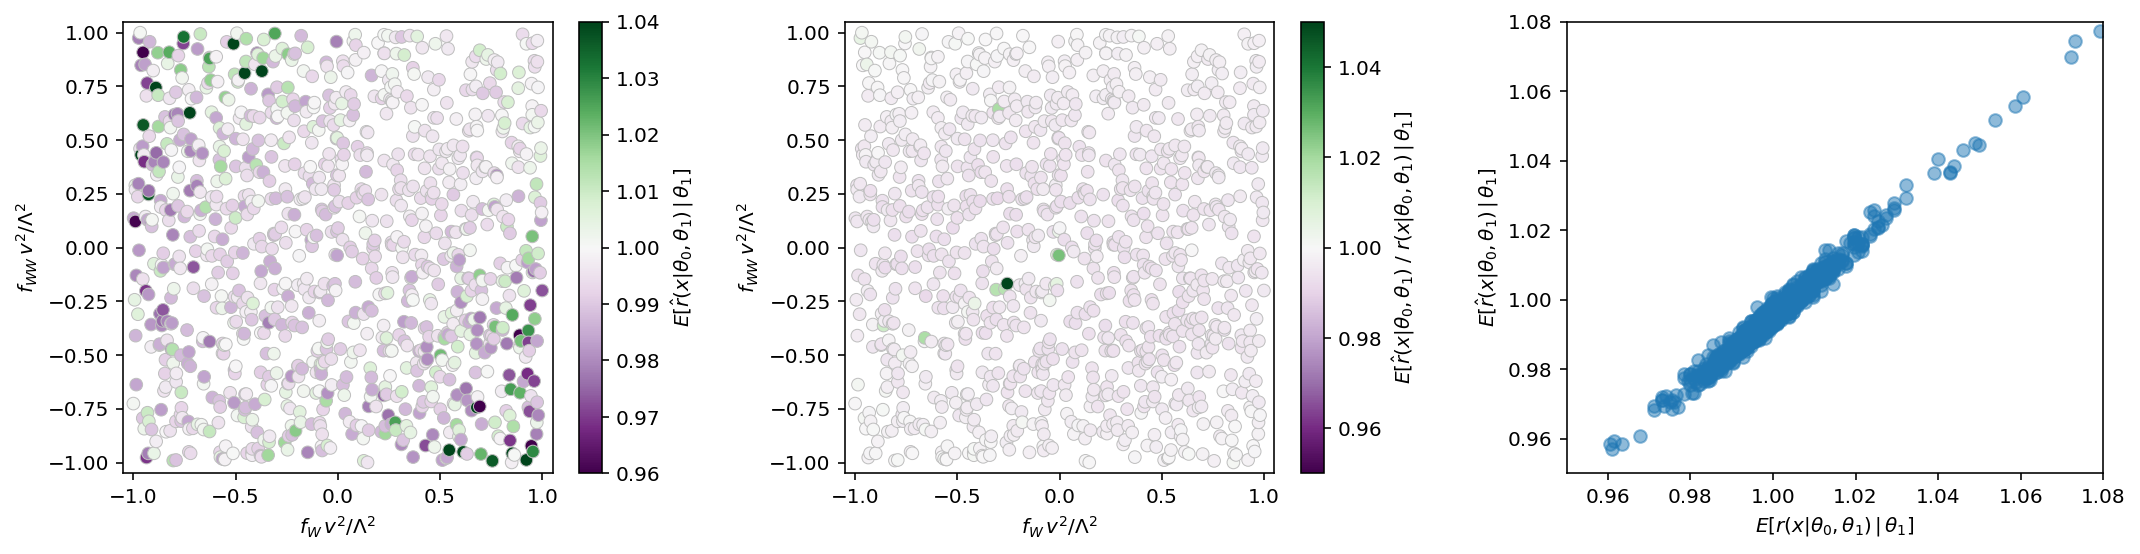

In [13]:
plt.figure(figsize=(15,4))




plt.subplot(1,3,1)

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=expected_rhat,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='PRGn',
            vmin=0.96, vmax=1.04)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$E[\hat{r}(x | \theta_0, \theta_1) \,|\, \theta_1]$')



plt.subplot(1,3,2)

plt.scatter(settings.thetas[:,0], settings.thetas[:,1], c=error,
            s=40.,
            edgecolor='0.75', lw=0.5,
            cmap='PRGn',
            vmin=0.95, vmax=1.05)

cbar = plt.colorbar()

plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'$E[\hat{r}(x | \theta_0, \theta_1) \; / \; r(x | \theta_0, \theta_1) \,|\, \theta_1]$')



plt.subplot(1,3,3)

plt.scatter(expected_r, expected_rhat,
            s=40., alpha=0.5, c='C0')

plt.xlim(0.95,1.08)
plt.ylim(0.95,1.08)
plt.xlabel(r'$E[r(x | \theta_0, \theta_1) \,|\, \theta_1]$')
plt.ylabel(r'$E[\hat{r}(x | \theta_0, \theta_1) \,|\, \theta_1]$')



plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


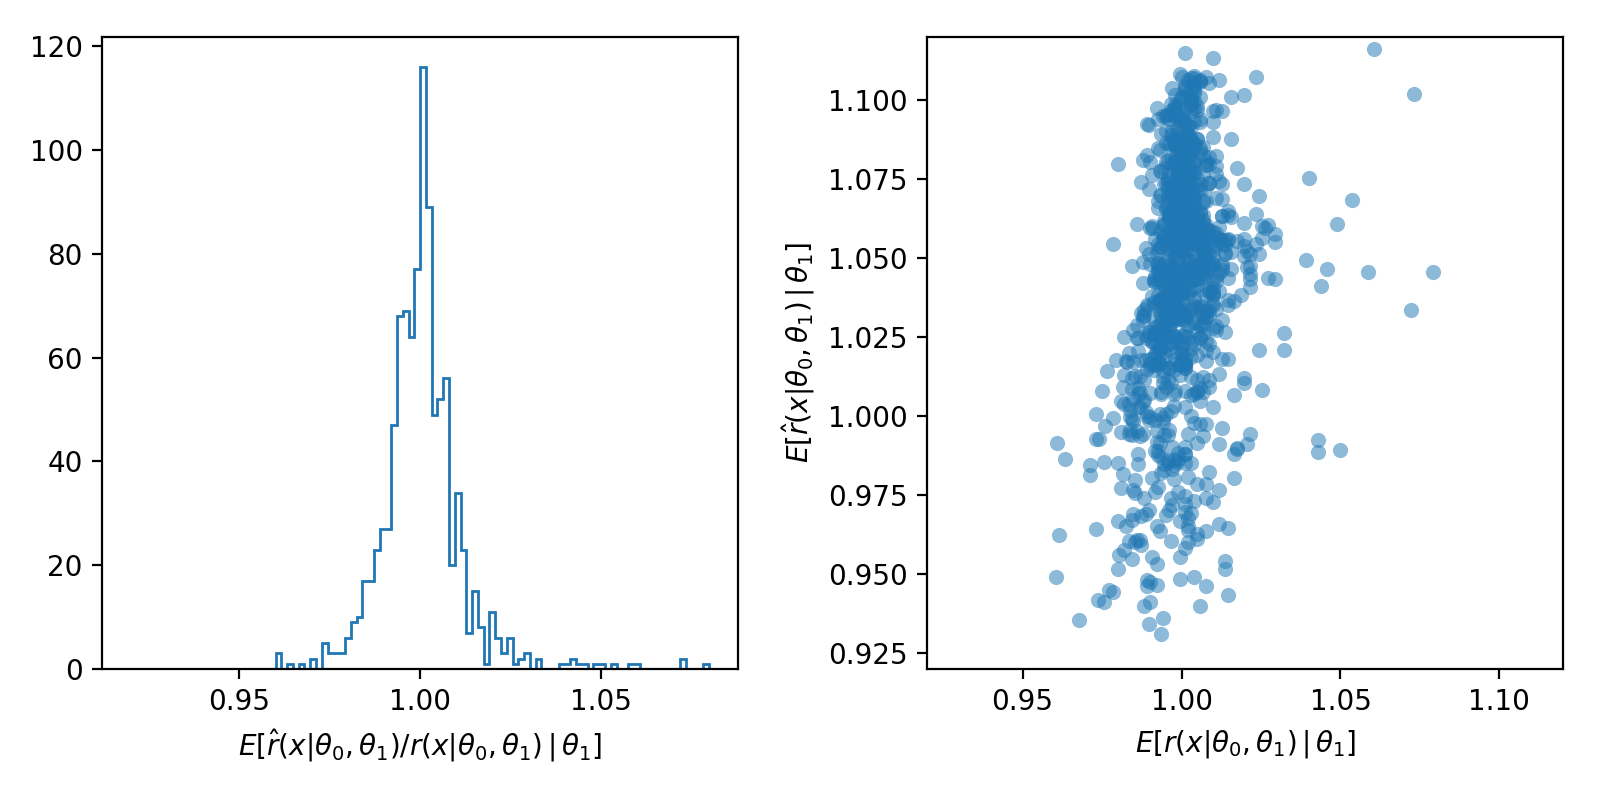

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [29]:
plt.figure(figsize=(8,4))



plt.subplot(1,2,1)

plt.hist(expected_r, bins=100, range=(0.92,1.08), histtype='step')
plt.xlabel(r"$E[\hat{r}(x | \theta_0, \theta_1) / r(x | \theta_0, \theta_1) \,|\, \theta_1]$")



plt.subplot(1,2,2)

plt.scatter(expected_r, expected_rhat,
            s=30., alpha=0.5, c='C0', lw=0.)

plt.xlim(0.92,1.12)
plt.ylim(0.92,1.12)
plt.xlabel(r"$E[r(x | \theta_0, \theta_1) \,|\, \theta_1]$")
plt.ylabel(r"$E[\hat{r}(x | \theta_0, \theta_1) \,|\, \theta_1]$")



plt.tight_layout()
plt.show()
